In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pip install lifelines

     |████████████████████████████████| 348 kB 4.2 MB/s 
     |████████████████████████████████| 55 kB 3.9 MB/s 
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4048 sha256=2b59dc13c33ed13dad61c0f962c0be13e5e6568f3b2e318914e7058844dd8b82
  Stored in directory: /root/.cache/pip/wheels/9f/01/ee/1331593abb5725ff7d8c1333aee93a50a1c29d6ddda9665c9f
Successfully built autograd-gamma


# Applying Survival model

## 1. 학습하기

## 1-1. Cox Proportional Hazard Model

In [3]:
from google.colab import files 
uploaded = files.upload()

Saving opt-target.csv to opt-target.csv
Saving X_iter_imputed.csv to X_iter_imputed.csv


In [4]:
import io
feature = pd.read_csv(io.BytesIO(uploaded['X_iter_imputed.csv'])) 
optimal_target = pd.read_csv(io.BytesIO(uploaded['opt-target.csv'])) 

In [8]:
opt_data = pd.merge(feature, optimal_target, on = 'SubjectID')
opt_data = opt_data.drop(columns=['SubjectID','Unnamed: 0_x', 'Unnamed: 0_y'])
opt_data['mean_Q1_2_3_mouth'] = opt_data['mean_Q1_Speech'] + opt_data['mean_Q2_Salivation'] + opt_data['mean_Q3_Swallowing']
opt_data['mean_Q8_9_leg'] = opt_data['mean_Q8_Walking'] + opt_data['mean_Q9_Climbing_Stairs']
opt_data = opt_data[['Age', 'onset_delta', 'fvc_mean', 'Creatinine_mean', 
                     'alsfrs_total_slope',  'mean_Q1_2_3_mouth',   'mean_Q5_Cutting', 'mean_Q8_9_leg', 
                     'slope_Q1_Speech', 'slope_Q2_Salivation',   'slope_Q3_Swallowing', 'slope_Q4_Handwriting', 
                     'slope_Q5_Cutting', 'slope_Q9_Climbing_Stairs', 'weight_slope', 'status_opt', 'time_opt']]

In [10]:
opt_data[opt_data['time_opt']==0]

,Age,onset_delta,fvc_mean,Creatinine_mean,alsfrs_total_slope,mean_Q1_2_3_mouth,mean_Q5_Cutting,mean_Q8_9_leg,slope_Q1_Speech,slope_Q2_Salivation,slope_Q3_Swallowing,slope_Q4_Handwriting,slope_Q5_Cutting,slope_Q9_Climbing_Stairs,weight_slope,status_opt,time_opt
4,59.0,-638.0,94.0,87.488065,-0.080037,9.0,2.0,4.0,-0.003074,-0.011257,-0.042773,-0.004546,0.007394,-0.000021,-0.170955,0,0
7,62.0,-522.0,91.0,92.675242,0.016491,12.0,2.0,8.0,0.011249,-0.020727,0.001035,0.040328,-0.031118,0.004789,0.068435,0,0
15,60.0,-587.0,89.0,102.102328,-0.044872,9.0,4.0,8.0,-0.004361,-0.012385,0.000108,0.007448,0.001097,-0.009769,-0.122346,0,0
36,73.0,-1110.0,89.0,69.633115,-0.055988,12.0,4.0,4.0,-0.012488,-0.003756,-0.017899,-0.000184,0.019605,-0.016537,-0.090941,0,0
38,49.0,-468.0,72.0,43.724685,0.001206,12.0,3.0,3.0,-0.003296,-0.000930,-0.001179,-0.001650,-0.001600,0.028560,-0.045336,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3150,68.0,-434.0,92.0,86.081273,-0.045743,7.0,4.0,3.0,-0.026326,-0.012390,0.004354,-0.004891,0.002783,0.007150,-0.064803,0,0
3167,68.0,-786.0,89.0,95.337728,-0.003820,9.0,2.0,4.0,0.015133,0.019283,0.009631,-0.031042,0.013273,-0.006396,-0.111496,0,0
3221,59.0,-377.0,91.0,62.000000,-0.014579,10.0,3.0,4.0,0.000582,0.015175,0.003043,-0.011373,0.013630,-0.011967,0.000681,0,0
3228,55.0,-708.0,53.0,88.729941,0.008692,10.0,1.0,1.0,-0.011826,0.022997,-0.022022,0.001300,-0.007941,0.012293,-0.036218,0,0


In [13]:
opt_data = opt_data[opt_data['time_opt']!=0]
y = opt_data[['status_opt']]

In [14]:
from sklearn.model_selection import train_test_split

df_train, df_test, y_train, y_test = train_test_split(opt_data, y, train_size=0.8, test_size=0.2, random_state=11)

In [15]:
df_test.iloc[:,:-2]

,Age,onset_delta,fvc_mean,Creatinine_mean,alsfrs_total_slope,mean_Q1_2_3_mouth,mean_Q5_Cutting,mean_Q8_9_leg,slope_Q1_Speech,slope_Q2_Salivation,slope_Q3_Swallowing,slope_Q4_Handwriting,slope_Q5_Cutting,slope_Q9_Climbing_Stairs,weight_slope
1448,58.0,-1718.0,70.333333,88.400000,-5.000000e-02,6.500000,2.5,5.000000,-0.016667,-0.016667,-0.016667,0.000000,-0.016667,0.000000,0.000000
2335,42.0,-950.0,84.666667,88.400000,6.540911e-02,11.000000,1.0,4.625000,0.000000,0.000000,0.000000,0.032787,0.000000,0.016393,0.003279
3033,46.0,-510.0,95.500000,88.400000,-2.841520e-02,9.500000,3.8,5.200000,-0.014286,0.000000,0.014286,-0.014286,-0.014286,-0.028571,-0.034286
1355,49.0,-911.0,72.250000,88.400000,-1.711185e-01,10.800000,1.3,4.300000,-0.015385,0.000000,0.000000,-0.046154,-0.015385,-0.015385,-0.021538
2411,74.0,-690.0,115.000000,88.400000,0.000000e+00,12.000000,4.0,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2958,63.0,-994.0,82.666667,85.223495,-1.714583e-02,12.000000,4.0,5.333333,0.000000,0.000000,0.000000,0.016129,0.000000,-0.032258,0.045017
802,70.0,-585.0,87.716388,72.930000,2.018396e-02,9.000000,4.0,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.016216
2330,66.0,-913.0,83.000000,32.979515,2.142857e-01,9.500000,3.5,3.000000,0.000000,0.000000,0.071429,0.071429,0.071429,0.000000,0.053571
1274,52.0,-382.0,61.666667,62.000000,1.522514e-16,12.000000,2.0,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.006061


In [16]:
df_train

,Age,onset_delta,fvc_mean,Creatinine_mean,alsfrs_total_slope,mean_Q1_2_3_mouth,mean_Q5_Cutting,mean_Q8_9_leg,slope_Q1_Speech,slope_Q2_Salivation,slope_Q3_Swallowing,slope_Q4_Handwriting,slope_Q5_Cutting,slope_Q9_Climbing_Stairs,weight_slope,status_opt,time_opt
1860,71.0,-677.0,86.000000,59.670000,-1.111111e-01,11.50,3.5,5.500000,0.000000,-0.015873,0.000000,-0.015873,-0.015873,-0.031746,-0.031746,0,374
772,54.0,-921.0,67.250000,88.400000,-4.218472e-02,8.80,1.3,2.300000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.015152,-0.045455,1,40
1623,60.0,-311.0,68.785603,80.400000,-1.033708e-02,12.00,4.0,3.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.005618,0,425
1146,50.0,-961.0,62.500000,81.800000,1.923077e-02,8.50,2.5,8.000000,0.000000,0.000000,-0.019231,0.000000,0.019231,0.000000,-0.028846,1,416
2272,68.0,-570.0,106.966121,65.416000,-2.675367e-02,11.75,4.0,7.000000,0.000000,0.000000,0.014085,0.000000,0.000000,-0.028169,0.009859,0,411
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
357,62.0,-234.0,119.500000,88.800000,-5.263158e-02,10.50,3.5,3.500000,-0.026316,0.000000,-0.052632,-0.026316,0.026316,0.000000,0.034211,1,38
1346,48.0,-601.0,88.250000,88.400000,-3.726206e-02,10.90,4.0,2.600000,0.000000,-0.014286,0.000000,0.000000,0.000000,-0.014286,-0.130000,0,265
3286,51.0,-282.0,64.750000,88.400000,-1.340513e-02,8.60,3.2,4.000000,-0.012987,-0.012987,0.000000,0.000000,0.012987,0.000000,-0.048193,0,110
1153,66.0,-717.0,96.689228,80.000000,-1.691521e-16,12.00,4.0,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.017241,0,58


모델 적용하기

In [17]:
from lifelines import CoxPHFitter
cph = CoxPHFitter(penalizer=0.01)
cph.fit(df_train, 'time_opt', event_col='status_opt')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 2659 total observations, 1742 right-censored observations>
             duration col = 'time_opt'
                event col = 'status_opt'
                penalizer = 0.01
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 2659
number of events observed = 917
   partial log-likelihood = -5990.67
         time fit was run = 2021-07-29 15:12:30 UTC

---
                           coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                        
Age                        0.02       1.02       0.00             0.01             0.02                 1.01                 1.02
onset_delta                0.00       1.00       0.00             0.00             0.00                 1.00                 1.00
fvc_mean                  -0.01       0.99       0.00            -0.01            -0.00                 0.99                 1.00
Creatinine_mean           -0.00       1.00       0.00            -0.01             0.00                 0.99                 1.00
alsfrs_total_slope        -4.02       0.02       0.93            -5.84            -2.20                 0.00                 0.11
mean_Q1_2_3_mouth         -0.51       0.60       0.02            -0.54            -0.47                 0.58                 0.62
mean_Q5_Cutting           -0.18       0.84       0.03            -0.24            -0.12                 0.79                 0.89
mean_Q8_9_leg             -0.03       0.97       0.02            -0.07             0.00                 0.93                 1.00
slope_Q1_Speech            1.36       3.89       2.21            -2.97             5.69                 0.05               295.17
slope_Q2_Salivation        2.03       7.61       2.51            -2.89             6.94                 0.06              1037.65
slope_Q3_Swallowing      -12.31       0.00       2.18           -16.58            -8.04                 0.00                 0.00
slope_Q4_Handwriting       8.32    4121.49       2.43             3.55            13.10                34.91             4.87e+05
slope_Q5_Cutting           2.42      11.27       2.22            -1.93             6.78                 0.14               878.85
slope_Q9_Climbing_Stairs   0.24       1.27       2.18            -4.04             4.51                 0.02                91.36
weight_slope              -2.37       0.09       0.57            -3.49            -1.25                 0.03                 0.29

                              z      p   -log2(p)
covariate                                        
Age                        6.55 <0.005      33.98
onset_delta                7.02 <0.005      38.71
fvc_mean                  -3.49 <0.005      11.03
Creatinine_mean           -0.95   0.34       1.55
alsfrs_total_slope        -4.32 <0.005      15.97
mean_Q1_2_3_mouth        -28.88 <0.005     606.67
mean_Q5_Cutting           -5.72 <0.005      26.48
mean_Q8_9_leg             -1.77   0.08       3.69
slope_Q1_Speech            0.61   0.54       0.89
slope_Q2_Salivation        0.81   0.42       1.26
slope_Q3_Swallowing       -5.65 <0.005      25.86
slope_Q4_Handwriting       3.42 <0.005      10.64
slope_Q5_Cutting           1.09   0.28       1.86
slope_Q9_Climbing_Stairs   0.11   0.91       0.13
weight_slope              -4.16 <0.005      14.96
---
Concordance = 0.84
Partial AIC = 12011.33
log-likelihood ratio test = 1151.73 on 15 df
-log2(p) of ll-ratio test = 782.05

In [18]:
print(cph.check_assumptions(df_train))

The ``p_value_threshold`` is set at 0.01. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 2659 total observations, 1742 right-censored observations>
         test_name = proportional_hazard_test

---
                               test_statistic      p  -log2(p)
Age                      km              0.03   0.85      0.23
                         rank            0.04   0.85      0.24
Creatinine_mean          km              0.19   0.66      0.60
                         rank            0.40   0.53      0.93
alsfrs_total_slope       km              1.78   0.18      2.45
                         rank            2.30   0.13      2.95
fvc_mean                 km              5.57   0.02      5.77
                         rank            9.69 <0.005      9.07
mean_Q1_2_3_mouth        km             46.97 <0.005     37.01
                         rank           47.26 <0.005     37.22
mean_Q5_Cutting          km              2.68   0.10      3.30
                         rank            3.68   0.06      4.18
mean_Q8_9_leg            km              9.58 <0.005      8.99
                         rank            3.02   0.08      3.60
onset_delta              km             19.75 <0.005     16.79
                         rank           27.54 <0.005     22.63
slope_Q1_Speech          km              2.31   0.13      2.96
                         rank            3.31   0.07      3.86
slope_Q2_Salivation      km              0.92   0.34      1.57
                         rank            0.46   0.50      1.00
slope_Q3_Swallowing      km             27.32 <0.005     22.47
                         rank           37.31 <0.005     29.89
slope_Q4_Handwriting     km              9.21 <0.005      8.69
                         rank           13.51 <0.005     12.04
slope_Q5_Cutting         km              3.25   0.07      3.81
                         rank            2.45   0.12      3.09
slope_Q9_Climbing_Stairs km              1.13   0.29      1.79
                         rank            1.34   0.25      2.01
weight_slope             km              0.68   0.41      1.29
                         rank            1.15   0.28      1.81



1. Variable 'onset_delta' failed the non-proportional test: p-value is <5e-05.

   Advice 1: the functional form of the variable 'onset_delta' might be incorrect. That is, there
may be non-linear terms missing. The proportional hazard test used is very sensitive to incorrect
functional forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'onset_delta' using pd.cut, and then specify it in
`strata=['onset_delta', ...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


2. Variable 'fvc_mean' failed the non-proportional test: p-value is 0.0019.

   Advice 1: the functional form of the variable 'fvc_mean' might be incorrect. That is, there may
be non-linear terms missing. The proportional hazard test used is very sensitive to incorrect
functional forms. See documentation in link [D] below on how to specify 

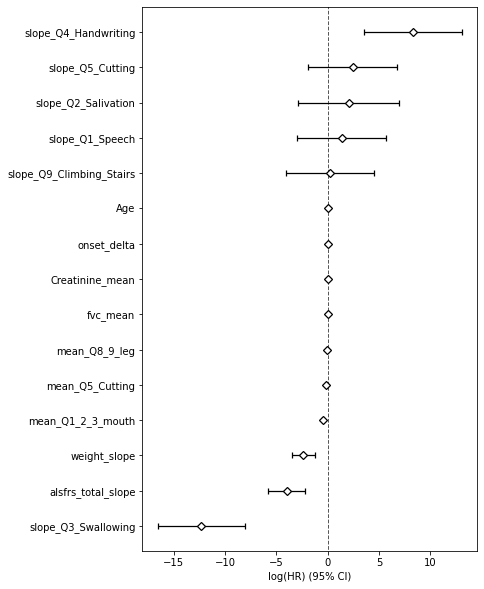

In [20]:
plt.figure(figsize=(6,10))
ax = cph.plot(c='k', marker='D', )
ax.yaxis.set_visible(True)
#HR >1, 즉 log(HR)>0 이면 사망 위험 증가를 뜻함

##1-2. Accelarated Failure Time model

In [21]:
from lifelines import WeibullAFTFitter

aft = WeibullAFTFitter()
aft.fit(df_train, duration_col='time_opt', event_col='status_opt', ancillary=False)

aft.print_summary()

<lifelines.WeibullAFTFitter: fitted with 2659 total observations, 1742 right-censored observations>
             duration col = 'time_opt'
                event col = 'status_opt'
   number of observations = 2659
number of events observed = 917
           log-likelihood = -6444.27
         time fit was run = 2021-07-29 15:20:56 UTC

---
                                   coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
param   covariate                                                                                                                        
lambda_ Age                       -0.01       0.99       0.00            -0.02            -0.01                 0.98                 0.99
        Creatinine_mean            0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
        alsfrs_total_slope         2.75      15.72       0.63             1.51             4.00                 4.55                54.34
        fvc_mean                   0.00       1.00       0.00             0.00             0.01                 1.00                 1.01
        mean_Q1_2_3_mouth          0.32       1.38       0.01             0.30             0.34                 1.34                 1.41
        mean_Q5_Cutting            0.11       1.12       0.02             0.08             0.15                 1.08                 1.17
        mean_Q8_9_leg              0.02       1.02       0.01            -0.01             0.04                 0.99                 1.04
        onset_delta               -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
        slope_Q1_Speech           -1.21       0.30       1.46            -4.06             1.65                 0.02                 5.19
        slope_Q2_Salivation       -1.71       0.18       1.59            -4.82             1.40                 0.01                 4.06
        slope_Q3_Swallowing        6.92    1009.34       1.42             4.13             9.70                62.33             16344.10
        slope_Q4_Handwriting      -5.52       0.00       1.60            -8.66            -2.38                 0.00                 0.09
        slope_Q5_Cutting          -1.56       0.21       1.43            -4.36             1.25                 0.01                 3.50
        slope_Q9_Climbing_Stairs  -0.72       0.49       1.46            -3.57             2.14                 0.03                 8.47
        weight_slope               1.57       4.83       0.36             0.87             2.28                 2.39                 9.73
        Intercept                  2.73      15.29       0.20             2.34             3.12                10.37                22.55
rho_    Intercept                  0.48       1.61       0.02             0.43             0.52                 1.54                 1.69

                                     z      p   -log2(p)
param   covariate                                       
lambda_ Age                      -7.30 <0.005      41.63
        Creatinine_mean           1.17   0.24       2.06
        alsfrs_total_slope        4.35 <0.005      16.18
        fvc_mean                  3.28 <0.005       9.89
        mean_Q1_2_3_mouth        26.12 <0.005     497.10
        mean_Q5_Cutting           5.77 <0.005      26.92
        mean_Q8_9_leg             1.38   0.17       2.56
        onset_delta              -7.38 <0.005      42.57
        slope_Q1_Speech          -0.83   0.41       1.30
        slope_Q2_Salivation      -1.08   0.28       1.83
        slope_Q3_Swallowing       4.87 <0.005      19.76
        slope_Q4_Handwriting     -3.44 <0.005      10.77
        slope_Q5_Cutting         -1.09   0.28       1.85
        slope_Q9_Climbing_Stairs -0.49   0.62       0.68
        weight_slope              4.40 <0.005      16.51
        Intercept                13.76 <0.005     140.66
rho_    Inte

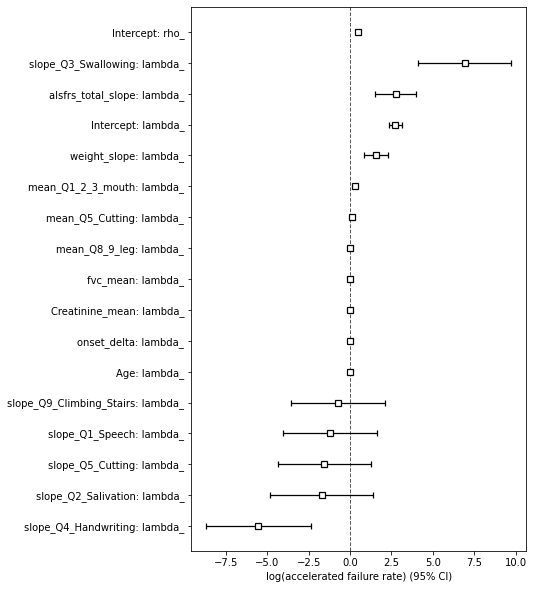

In [22]:
from matplotlib import pyplot as plt

aft = WeibullAFTFitter().fit(df_train, 'time_opt', 'status_opt', ancillary=False)
plt.figure(figsize=(6,10))
aft.plot()

## 1-3. Random Survival Forest model

In [24]:
!pip install --upgrade pip
!pip uninstall --yes --quiet osqp
!pip install -U scikit-survival

     |████████████████████████████████| 1.6 MB 4.2 MB/s 
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3
distutils: /usr/local/lib/python3.7/dist-packages
sysconfig: /usr/lib/python3.7/site-packages
distutils: /usr/local/lib/python3.7/dist-packages
sysconfig: /usr/lib/python3.7/site-packages
distutils: /usr/local/include/python3.7/UNKNOWN
sysconfig: /usr/include/python3.7m/UNKNOWN
distutils: /usr/local/bin
sysconfig: /usr/bin
distutils: /usr/local
sysconfig: /usr
user = False
home = None
root = None
prefix = None
     |████████████████████████████████| 2.4 MB 4.2 MB/s 
  distutils: /usr/lib/python3/dist-packages
  sysconfig: /usr/lib/python3.7/site-packages
  user = False
  home = None
  root = None
  prefix = None
  distutils: /usr/lib/python3/dist-packages
  sysconfig: /usr/lib/python3.7/site-packages
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
 

In [25]:
from sksurv.ensemble import RandomSurvivalForest

In [26]:
dic = {1:True, 0:False}

df_train_rsf = df_train.iloc[:, -2:][['status_opt', 'time_opt']]
df_train_rsf = df_train_rsf.replace({'status_opt':dic})

In [27]:
arr_1 = list(tuple(x) for x in df_train_rsf.to_records(index=False))
dt = np.dtype('bool, float')
y_train_rsf = np.array(arr_1, dtype=dt)
y_train_rsf.dtype.names=['cens', 'time']
y_train_rsf

array([(False, 374.), ( True,  40.), (False, 425.), ..., (False, 110.),
       (False,  58.), (False, 399.)],
      dtype=[('cens', '?'), ('time', '<f8')])

In [28]:
df_test_rsf = df_test.iloc[:, -2:][['status_opt', 'time_opt']]
df_test_rsf = df_test_rsf.replace({'status_opt':dic})

In [29]:
arr_2 = list(tuple(x) for x in df_test_rsf.to_records(index=False))
dt=np.dtype('bool, float')
y_test_rsf = np.array(arr_2, dtype=dt)
y_test_rsf.dtype.names=['cens', 'time']
y_test_rsf

array([(False, 3.850e+02), (False, 2.920e+02), (False, 2.770e+02),
       (False, 6.500e+01), (False, 2.720e+02), ( True, 1.100e+02),
       (False, 3.950e+02), ( True, 9.900e+01), (False, 3.640e+02),
       (False, 4.010e+02), ( True, 2.940e+02), (False, 3.430e+02),
       ( True, 9.100e+01), (False, 3.730e+02), (False, 1.330e+02),
       (False, 3.860e+02), (False, 2.340e+02), ( True, 9.100e+01),
       (False, 2.740e+02), ( True, 2.870e+02), (False, 1.890e+02),
       (False, 4.090e+02), ( True, 3.710e+02), ( True, 9.500e+01),
       (False, 9.100e+01), (False, 3.900e+02), ( True, 4.200e+01),
       (False, 3.740e+02), (False, 3.690e+02), ( True, 2.860e+02),
       ( True, 4.300e+01), (False, 1.056e+03), (False, 6.570e+02),
       ( True, 3.150e+02), (False, 4.340e+02), ( True, 2.100e+01),
       (False, 3.400e+02), (False, 2.030e+02), (False, 3.830e+02),
       (False, 3.920e+02), ( True, 1.070e+02), ( True, 1.820e+02),
       ( True, 4.300e+01), (False, 2.650e+02), (False, 3.920e+

###GridSearchCV for RSF

In [30]:
from sklearn.model_selection import GridSearchCV

params ={
    'n_estimators':[100],
    'max_features':['auto', 'sqrt','log2', None],
    'min_samples_leaf':[8,12,18],
    'min_samples_split':[8,16,20]
}

In [31]:
rf = RandomSurvivalForest(random_state=0, n_jobs=-1)
grid_cv = GridSearchCV(rf, param_grid=params, cv=2, n_jobs=-1)
GG = grid_cv.fit(df_train.iloc[:,:-2], y_train_rsf)

In [32]:
print(grid_cv.best_score_)
print(grid_cv.best_params_)

0.8399262974074648
{'max_features': 'auto', 'min_samples_leaf': 12, 'min_samples_split': 8, 'n_estimators': 100}


In [33]:
rsf = RandomSurvivalForest(n_estimators=100,
                           min_samples_split=8,
                           min_samples_leaf=12,
                           max_features="auto",
                           n_jobs=-1,
                           random_state=20)
rsf.fit(df_train.iloc[:,:-2], y_train_rsf)

RandomSurvivalForest(bootstrap=True, max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None, min_samples_leaf=12,
                     min_samples_split=8, min_weight_fraction_leaf=0.0,
                     n_estimators=100, n_jobs=-1, oob_score=False,
                     random_state=20, verbose=0, warm_start=False)

In [34]:
feature_names = df_test.iloc[:, :-2].columns.tolist()
feature_names

['Age',
 'onset_delta',
 'fvc_mean',
 'Creatinine_mean',
 'alsfrs_total_slope',
 'mean_Q1_2_3_mouth',
 'mean_Q5_Cutting',
 'mean_Q8_9_leg',
 'slope_Q1_Speech',
 'slope_Q2_Salivation',
 'slope_Q3_Swallowing',
 'slope_Q4_Handwriting',
 'slope_Q5_Cutting',
 'slope_Q9_Climbing_Stairs',
 'weight_slope']

In [36]:
pip install eli5

distutils: /usr/local/lib/python3.7/dist-packages
sysconfig: /usr/lib/python3.7/site-packages
distutils: /usr/local/lib/python3.7/dist-packages
sysconfig: /usr/lib/python3.7/site-packages
distutils: /usr/local/include/python3.7/UNKNOWN
sysconfig: /usr/include/python3.7m/UNKNOWN
distutils: /usr/local/bin
sysconfig: /usr/bin
distutils: /usr/local
sysconfig: /usr
user = False
home = None
root = None
prefix = None
     |████████████████████████████████| 106 kB 4.2 MB/s 
  distutils: /usr/local/include/python3.7/eli5
  sysconfig: /usr/include/python3.7m/eli5


In [40]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(rsf, n_iter=15, random_state=20)
perm.fit(df_train.iloc[:, :-2], y_train_rsf)

PermutationImportance(cv='prefit',
                      estimator=RandomSurvivalForest(bootstrap=True,
                                                     max_depth=None,
                                                     max_features='auto',
                                                     max_leaf_nodes=None,
                                                     max_samples=None,
                                                     min_samples_leaf=12,
                                                     min_samples_split=8,
                                                     min_weight_fraction_leaf=0.0,
                                                     n_estimators=100,
                                                     n_jobs=-1, oob_score=False,
                                                     random_state=20, verbose=0,
                                                     warm_start=False),
                      n_iter=15, random_state=20, refit=True, scoring=No

In [41]:
eli5.explain_weights_df(perm, feature_names=feature_names).describe()

,weight,std
count,15.000000,15.000000
mean,0.021753,0.001081
std,0.047733,0.001575
min,0.001320,0.000128
25%,0.004749,0.000380
50%,0.010265,0.000700
75%,0.015669,0.001061
max,0.192930,0.006604


In [42]:
A = eli5.show_weights(perm, feature_names=feature_names)
A

Weight,Feature
0.1929 ± 0.0132,mean_Q1_2_3_mouth
0.0189 ± 0.0025,slope_Q3_Swallowing
0.0176 ± 0.0025,alsfrs_total_slope
0.0161 ± 0.0021,fvc_mean
0.0153 ± 0.0021,onset_delta
0.0143 ± 0.0021,mean_Q5_Cutting
0.0113 ± 0.0014,Age
0.0103 ± 0.0012,weight_slope
0.0095 ± 0.0011,mean_Q8_9_leg
0.0057 ± 0.0016,slope_Q1_Speech


In [ ]:
BB = pd.read_csv('BB2.csv')
BB = BB.transpose()
BB.columns = ['mean_Bulbar', 'slope_Q3_Swallowing', 'mean_motor',
       'slope_alsfrs_tot', 'fvc_mean', 'onset_site', 'Age', 'slope_Q2_Salivation',
              'mean_Q10_Respiratory', 'fvc_slope','onset_delta', 'slope_Q7_Turning_in_Bed','slope_Q1_Speech',
       'slope_Q6_Dressing_and_Hygiene','slope_Q4_Handwriting',
        'slope_Q10_Respiratory','diag_minus_onset', 'Gender',
        'slope_Q9_Climbing_Stairs', 'slope_Q8_Walking', 'slope_Q5_Cutting']
BB = BB.iloc[1:, :]
BB = BB.drop('std')
BB

,mean_Bulbar,slope_Q3_Swallowing,mean_motor,slope_alsfrs_tot,fvc_mean,onset_site,Age,slope_Q2_Salivation,mean_Q10_Respiratory,fvc_slope,...,slope_Q7_Turning_in_Bed,slope_Q1_Speech,slope_Q6_Dressing_and_Hygiene,slope_Q4_Handwriting,slope_Q10_Respiratory,diag_minus_onset,Gender,slope_Q9_Climbing_Stairs,slope_Q8_Walking,slope_Q5_Cutting
weight,0.143737,0.0157985,0.0128258,0.00880817,0.00483118,0.00335615,0.00322537,0.00269125,0.00267886,0.00253088,...,0.000761948,0.000273255,0.000235399,7.43e-05,4.13e-06,-4.27e-05,-8.88e-05,-0.000136283,-0.000317995,-0.000536
max,0.156562,0.0177916,0.0155109,0.0110794,0.00656415,0.00676846,0.00475516,0.0037663,0.00376564,0.00401008,...,0.00128953,0.00221014,0.000945378,0.000458138,0.000458045,0.000397442,0.000497132,0.000161263,0.000170726,0.000111
min,0.130912,0.0138055,0.0101407,0.00653692,0.00309821,-5.62e-05,0.00169559,0.0016162,0.00159209,0.00105168,...,0.000234364,-0.00166363,-0.000474581,-0.000309465,-0.000449785,-0.000482792,-0.000674713,-0.00043383,-0.000806715,-0.001183


Text(0, 0.5, '')

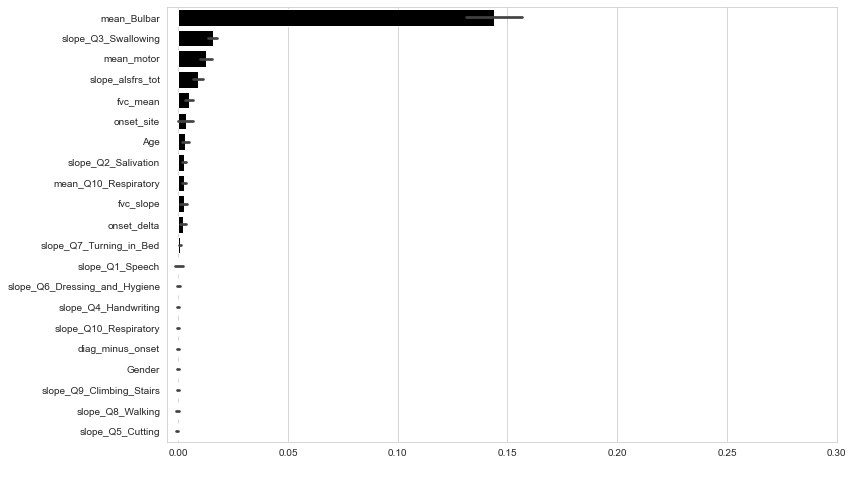

In [ ]:
df = pd.DataFrame(data=BB, columns=['mean_Bulbar', 'slope_Q3_Swallowing', 'mean_motor',
       'slope_alsfrs_tot', 'fvc_mean', 'onset_site', 'Age', 'slope_Q2_Salivation',
              'mean_Q10_Respiratory', 'fvc_slope','onset_delta', 'slope_Q7_Turning_in_Bed','slope_Q1_Speech',
       'slope_Q6_Dressing_and_Hygiene','slope_Q4_Handwriting',
        'slope_Q10_Respiratory','diag_minus_onset', 'Gender',
        'slope_Q9_Climbing_Stairs', 'slope_Q8_Walking', 'slope_Q5_Cutting'])

fig, ax = plt.subplots()
fig.set_size_inches(12, 8)
sns.set_style("whitegrid")
sns.barplot(x="value", y="variable", data=pd.melt(df), color='black')
ax.set_xlabel(' ')
ax.set_xlim([-0.005,0.3])
ax.set_ylabel('')

## 2. 평가하기

## 2-1. C-index 계산

## 2-1-1. Repeated 5-fold cross validation on Training set

Cox proportional hazard model

In [43]:
from lifelines.utils import k_fold_cross_validation

In [44]:
cph = CoxPHFitter(penalizer = 0.01)
C_Idx = np.array([])
random_num_list = [10,20,30,40,50,60,70,80,90,100]

for i in random_num_list:
    arr = k_fold_cross_validation(cph, df_train, 'time_opt', event_col='status_opt', k=5, scoring_method="concordance_index")
    C_Idx = np.concatenate((C_Idx, arr))
print(C_Idx)

[0.83790797 0.83373133 0.83173101 0.82231885 0.84514036 0.81940397
 0.8420628  0.83870165 0.8488974  0.82129025 0.8203821  0.83821577
 0.82529411 0.83949787 0.85425321 0.83024994 0.82073351 0.83288136
 0.83582512 0.84186008 0.83403354 0.84730461 0.81318945 0.83550647
 0.83792738 0.84794747 0.82942837 0.85082953 0.82165824 0.82232373
 0.8377555  0.84002583 0.84132255 0.82840157 0.82410175 0.81948887
 0.84855378 0.86048894 0.82694169 0.81740383 0.85149679 0.82084988
 0.81816963 0.83208803 0.83578933 0.83766212 0.84051442 0.85041879
 0.82056829 0.82574781]


Accelerated Failure Time

In [45]:
from lifelines import WeibullAFTFitter
aft = WeibullAFTFitter()
C_Idx_3 = np.array([])
random_num_list = [10,20,30,40,50,60,70,80,90,100]

for i in random_num_list:
    arr = k_fold_cross_validation(aft, df_train, 'time_opt', event_col='status_opt', k=5, scoring_method="concordance_index")
    C_Idx_3 = np.concatenate((C_Idx_3, arr))
print(C_Idx_3)

[0.84136783 0.83576763 0.82517325 0.83976093 0.81970537 0.84909796
 0.83708789 0.83730836 0.8281981  0.81253418 0.83570376 0.82289463
 0.83892786 0.83505481 0.82791543 0.8225211  0.83963296 0.82833046
 0.80854493 0.86939305 0.8407987  0.82242837 0.8299055  0.83773371
 0.84509603 0.83526041 0.83625592 0.83846194 0.8337544  0.82202451
 0.82963586 0.84484448 0.8304534  0.82085633 0.83327011 0.83359042
 0.83134447 0.83763248 0.82246893 0.84397945 0.85601437 0.82335661
 0.83174942 0.80604606 0.8401892  0.82453548 0.84194149 0.84281036
 0.81064367 0.8471394 ]


Random Survival Forest

In [46]:
df_train_rsf = df_train.iloc[:,:]

In [47]:
df_train_rsf = df_train_rsf.replace({'status_opt':dic})
df_train_rsf

,Age,onset_delta,fvc_mean,Creatinine_mean,alsfrs_total_slope,mean_Q1_2_3_mouth,mean_Q5_Cutting,mean_Q8_9_leg,slope_Q1_Speech,slope_Q2_Salivation,slope_Q3_Swallowing,slope_Q4_Handwriting,slope_Q5_Cutting,slope_Q9_Climbing_Stairs,weight_slope,status_opt,time_opt
1860,71.0,-677.0,86.000000,59.670000,-1.111111e-01,11.50,3.5,5.500000,0.000000,-0.015873,0.000000,-0.015873,-0.015873,-0.031746,-0.031746,False,374
772,54.0,-921.0,67.250000,88.400000,-4.218472e-02,8.80,1.3,2.300000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.015152,-0.045455,True,40
1623,60.0,-311.0,68.785603,80.400000,-1.033708e-02,12.00,4.0,3.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.005618,False,425
1146,50.0,-961.0,62.500000,81.800000,1.923077e-02,8.50,2.5,8.000000,0.000000,0.000000,-0.019231,0.000000,0.019231,0.000000,-0.028846,True,416
2272,68.0,-570.0,106.966121,65.416000,-2.675367e-02,11.75,4.0,7.000000,0.000000,0.000000,0.014085,0.000000,0.000000,-0.028169,0.009859,False,411
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
357,62.0,-234.0,119.500000,88.800000,-5.263158e-02,10.50,3.5,3.500000,-0.026316,0.000000,-0.052632,-0.026316,0.026316,0.000000,0.034211,True,38
1346,48.0,-601.0,88.250000,88.400000,-3.726206e-02,10.90,4.0,2.600000,0.000000,-0.014286,0.000000,0.000000,0.000000,-0.014286,-0.130000,False,265
3286,51.0,-282.0,64.750000,88.400000,-1.340513e-02,8.60,3.2,4.000000,-0.012987,-0.012987,0.000000,0.000000,0.012987,0.000000,-0.048193,False,110
1153,66.0,-717.0,96.689228,80.000000,-1.691521e-16,12.00,4.0,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.017241,False,58


In [48]:
C_Idx_2 = np.array([])

for i in random_num_list:
    df_train_rsf = df_train_rsf.sample(n=len(df_train_rsf), random_state=i)
    
    y_train_rsf_1 = np.array(list(tuple(x) for x in df_train_rsf.iloc[:2128,-2:].to_records(index=False)), dtype=dt)
    y_test_rsf_1 = np.array(list(tuple(x) for x in df_train_rsf.iloc[2128:,-2:].to_records(index=False)), dtype=dt)
    
    y_train_rsf_2 = np.array(list(tuple(x) for x in df_train_rsf.iloc[532:,-2:].to_records(index=False)), dtype=dt)
    y_test_rsf_2 = np.array(list(tuple(x) for x in df_train_rsf.iloc[0:532,-2:].to_records(index=False)), dtype=dt)
    
    y_train_rsf_3 = np.array(list(tuple(x) for x in df_train_rsf.iloc[np.r_[0:532,1064:],-2:].to_records(index=False)), dtype=dt)
    y_test_rsf_3 = np.array(list(tuple(x) for x in df_train_rsf.iloc[532:1064,-2:].to_records(index=False)), dtype=dt)
    
    y_train_rsf_4 = np.array(list(tuple(x) for x in df_train_rsf.iloc[np.r_[0:1064,1596:],-2:].to_records(index=False)), dtype=dt)
    y_test_rsf_4 = np.array(list(tuple(x) for x in df_train_rsf.iloc[1064:1596,-2:].to_records(index=False)), dtype=dt)
    
    y_train_rsf_5 = np.array(list(tuple(x) for x in df_train_rsf.iloc[np.r_[0:1596,2128:],-2:].to_records(index=False)), dtype=dt)
    y_test_rsf_5 = np.array(list(tuple(x) for x in df_train_rsf.iloc[1596:2128,-2:].to_records(index=False)), dtype=dt)
    
    
    rsf.fit(df_train_rsf.iloc[0:2128,:-2], y_train_rsf_1)
    sco_1 = rsf.score(df_train_rsf.iloc[2128:,:-2], y_test_rsf_1)
    
    rsf.fit(df_train_rsf.iloc[532:,:-2], y_train_rsf_2)
    sco_2 = rsf.score(df_train_rsf.iloc[0:532,:-2], y_test_rsf_2)
    
    rsf.fit(df_train_rsf.iloc[np.r_[0:532,1064:],:-2], y_train_rsf_3)
    sco_3 = rsf.score(df_train_rsf.iloc[532:1064,:-2], y_test_rsf_3)
    
    rsf.fit(df_train_rsf.iloc[np.r_[0:1064,1596:],:-2], y_train_rsf_4)
    sco_4 = rsf.score(df_train_rsf.iloc[1064:1596,:-2], y_test_rsf_4)
    
    rsf.fit(df_train_rsf.iloc[np.r_[0:1596,2128:],:-2], y_train_rsf_5)
    sco_5 = rsf.score(df_train_rsf.iloc[1596:2128,:-2], y_test_rsf_5)
    
    C_Idx_2 = np.append (C_Idx_2, [sco_1, sco_2, sco_3, sco_4, sco_5])

print(C_Idx_2)

[0.86303708 0.83229261 0.88400404 0.89792064 0.89448229 0.83207642
 0.8555585  0.89453087 0.90107973 0.88976205 0.85437821 0.84719346
 0.89467344 0.89753385 0.87586466 0.84497261 0.84926912 0.88318134
 0.90493577 0.88245631 0.84072233 0.83726746 0.89009003 0.89963722
 0.89686439 0.83229154 0.84478681 0.90398773 0.86975163 0.91145492
 0.83800964 0.8222721  0.88231005 0.90266281 0.90517199 0.84561158
 0.84742018 0.88432263 0.88626309 0.89732597 0.83298498 0.84776115
 0.89783818 0.89702551 0.89037343 0.83453315 0.85731334 0.86693032
 0.88978703 0.90968266]


Comparing C-index values between Cox & AFT & RSF

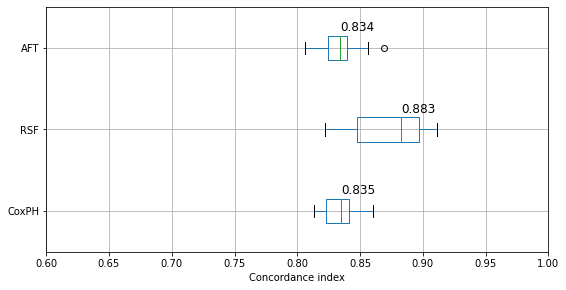

In [49]:
df = pd.DataFrame([C_Idx, C_Idx_2,C_Idx_3], index=['CoxPH', 'RSF','AFT'])
df2 = df.transpose()

colors = ['#000000', '#000000', '#ff7f00']
colors_setosa = dict(color=colors[0])
colors_versicolor = dict(color=colors[1])
colors_versicolor2 = dict(color=colors[2])

aft_median = np.median(df2['AFT'])
rsf_median = np.median(df2['RSF'])
cox_median = np.median(df2['CoxPH'])

fig, ax = plt.subplots(figsize=(9,4.5))
ax = df2.boxplot(column=['CoxPH', 'RSF', 'AFT'], vert=False)
plt.annotate(str(np.round(aft_median,3)), xy=(aft_median, 0.8)
                , xytext=(aft_median, 3.205) , fontsize=12)
plt.annotate(str(np.round(rsf_median,3)), xy=(aft_median, 0.8)
                , xytext=(rsf_median, 2.205) , fontsize=12)
plt.annotate(str(np.round(cox_median,3)), xy=(aft_median, 0.8)
                , xytext=(cox_median, 1.205) , fontsize=12)
plt.xlim([.6,1.0])
plt.xlabel('Concordance index')
plt.show()

## 2-1-2. C-index on Test set

In [51]:
from lifelines.utils import concordance_index
cph = CoxPHFitter(penalizer = 0.01).fit(df_train, 'time_opt', 'status_opt')
print('COXPH shows c-index ', concordance_index(df_test['time_opt'], -cph.predict_partial_hazard(df_test), df_test['status_opt']))

COXPH shows c-index  0.8379079488428469


In [52]:
aft = WeibullAFTFitter()
aft.fit(df_train, 'time_opt', event_col='status_opt')
print('AFT shows c-index ',concordance_index(df_test['time_opt'], aft.predict_median(df_test), df_test['status_opt']))

AFT shows c-index  0.8370130385038005


In [53]:
  rsf.fit(df_train.iloc[:,:-2], y_train_rsf)
  sco_test = rsf.score(df_test.iloc[:,:-2], y_test_rsf)
  print('RSF shows c-index ', sco_test)

RSF shows c-index  0.8471968916025692


비례위험 가정 검토

In [ ]:
print(cph.check_assumptions(training_df=df_test, p_value_threshold=0.05))

## 2-2. Individual Prediction on Test set

In [54]:
df_test_X = df_test.drop(columns=['time_opt', 'status_opt'])

In [55]:
# Selecting 3 random subjects to predict survival
test_1 = df_test_X.iloc[-7:-2, :]

Text(0.5, 1.0, 'COXPH')

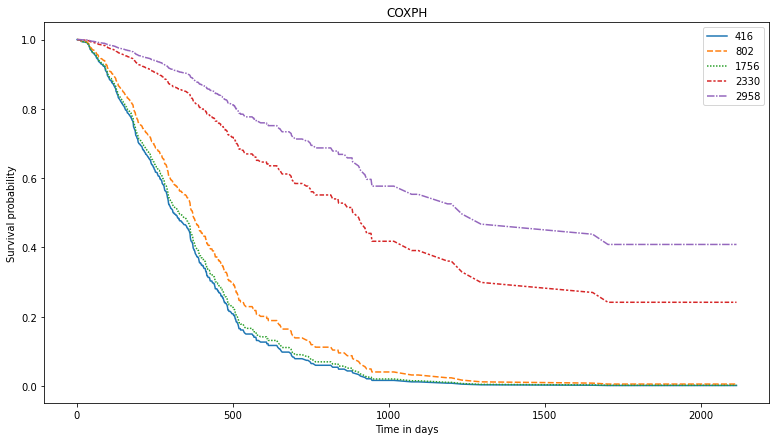

In [57]:
fig, ax = plt.subplots(figsize=(13,7))
result_cph = cph.predict_survival_function(test_1)
ax = sns.lineplot(data = result_cph)
ax.set(xlabel='Time in days', ylabel='Survival probability')
ax.set_title("COXPH")

Text(0.5, 1.0, 'AFT')

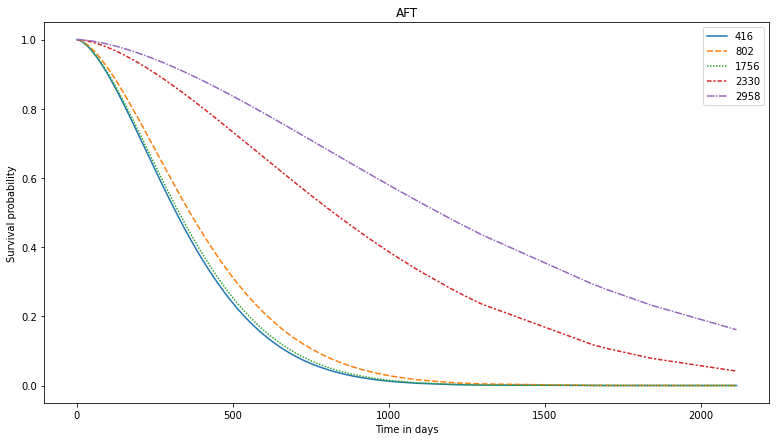

In [58]:
fig, ax = plt.subplots(figsize=(13,7))
result_aft = aft.predict_survival_function(test_1)
ax = sns.lineplot(data = result_aft)
ax.set(xlabel='Time in days', ylabel='Survival probability')
ax.set_title("AFT")

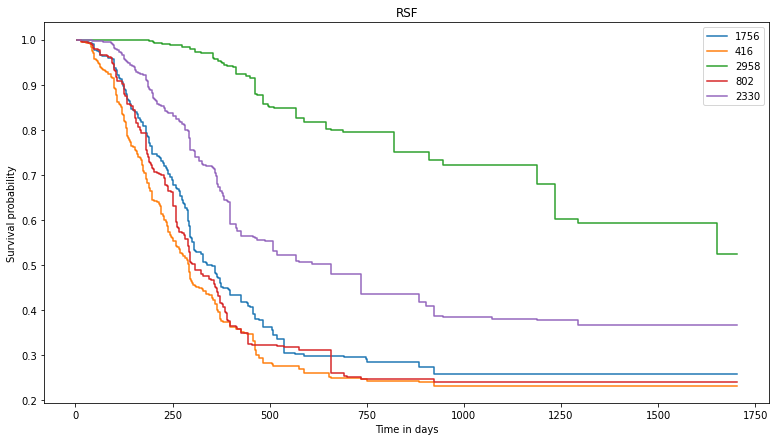

In [73]:
result_rsf = rsf.predict_survival_function(test_1, return_array=True)
fig, ax = plt.subplots(figsize=(13,7))
for i, s in enumerate(result_rsf):
    plt.step(rsf.event_times_, s, where="post")
    
plt.legend(labels = list(test_1.index))
plt.ylabel("Survival probability")
plt.xlabel("Time in days")
plt.title("RSF")
plt.show()